<a href="https://colab.research.google.com/github/RomanKhaykichev/A-B-testing/blob/main/Python_A_B_test_(sem)_%D0%BF%D1%80%D0%B8%D0%BC%D0%B5%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5_%D1%81%D1%82%D0%B0%D1%82%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D1%80%D0%B8%D1%82%D0%B5%D1%80%D0%B8%D0%B5%D0%B2_%D0%BD%D0%B0_%D0%BF%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B5_%D0%BF%D0%B0%D0%B9%D0%BF%D0%BB%D0%B0%D0%B9%D0%BD_%D0%BE%D1%86%D0%B5%D0%BD%D0%BA%D0%B8_A_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Python A_B test (sem) - применение статистических критериев на практике - пайплайн оценки A_B

Оцените результаты эксперимента:<p>
Стат значимо отличается ли ARPU в других группах?<p>
Какие рекомендации дадите менеджеру?

In [34]:
from scipy import stats
import numpy as np

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [6]:
#Подгружаем данные с гугл диска
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ab_stats-sem_8_materials.csv')

In [14]:
data

,revenue,num_purchases,purchase,ab_group,av_site visit
0,0.0,0,0,A,9.040174
1,0.0,0,0,A,4.811628
2,0.0,0,0,A,7.342623
3,0.0,0,0,A,7.744581
4,0.0,0,0,A,10.511814
...,...,...,...,...,...
23647,0.0,0,0,B,10.207152
23648,0.0,0,0,B,5.148761
23649,0.0,0,0,B,4.809019
23650,0.0,0,0,B,8.127488


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23652 entries, 0 to 23651
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   revenue        23652 non-null  float64
 1   num_purchases  23652 non-null  int64  
 2   purchase       23652 non-null  int64  
 3   ab_group       23652 non-null  object 
 4   av_site visit  23652 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 924.0+ KB


In [17]:
data = data.astype({'num_purchases': np.uint8}) # убираем отрицательные значения

In [18]:
data.describe()

,revenue,num_purchases,purchase,av_site visit
count,23652.000000,23652.000000,23652.000000,23652.000000
mean,0.324689,0.043590,0.020717,7.013112
std,9.557730,1.079403,0.142438,3.154584
min,0.000000,0.000000,0.000000,-12.073486
25%,0.000000,0.000000,0.000000,5.173787
50%,0.000000,0.000000,0.000000,7.007936
75%,0.000000,0.000000,0.000000,8.864119
max,1303.609284,152.000000,1.000000,22.446822


In [21]:
data[data['av_site visit'] < 0].ab_group.value_counts() # баг в подсчетах - кол-во минус значений

B    462
A      6
Name: ab_group, dtype: int64

In [22]:
468/23652

0.0197869101978691

In [24]:
data = data[data['av_site visit'] > 0] # убираем минусовые значения

In [25]:
group_a = data[data.ab_group == 'A']
group_b = data[data.ab_group == 'B']

In [26]:
group_a.describe()

,revenue,num_purchases,purchase,av_site visit
count,11829.000000,11829.000000,11829.000000,11829.000000
mean,0.404667,0.050723,0.021642,6.980379
std,13.136545,1.467883,0.145517,2.004450
min,0.000000,0.000000,0.000000,0.145466
25%,0.000000,0.000000,0.000000,5.657590
50%,0.000000,0.000000,0.000000,6.984166
75%,0.000000,0.000000,0.000000,8.346243
max,1303.609284,152.000000,1.000000,17.728836


In [27]:
group_b.describe()

,revenue,num_purchases,purchase,av_site visit
count,11355.000000,11355.000000,11355.000000,11355.000000
mean,0.245093,0.036548,0.019727,7.404806
std,3.192299,0.422820,0.139067,3.630412
min,0.000000,0.000000,0.000000,0.008679
25%,0.000000,0.000000,0.000000,4.746728
50%,0.000000,0.000000,0.000000,7.262590
75%,0.000000,0.000000,0.000000,9.889165
max,113.830000,25.000000,1.000000,22.446822


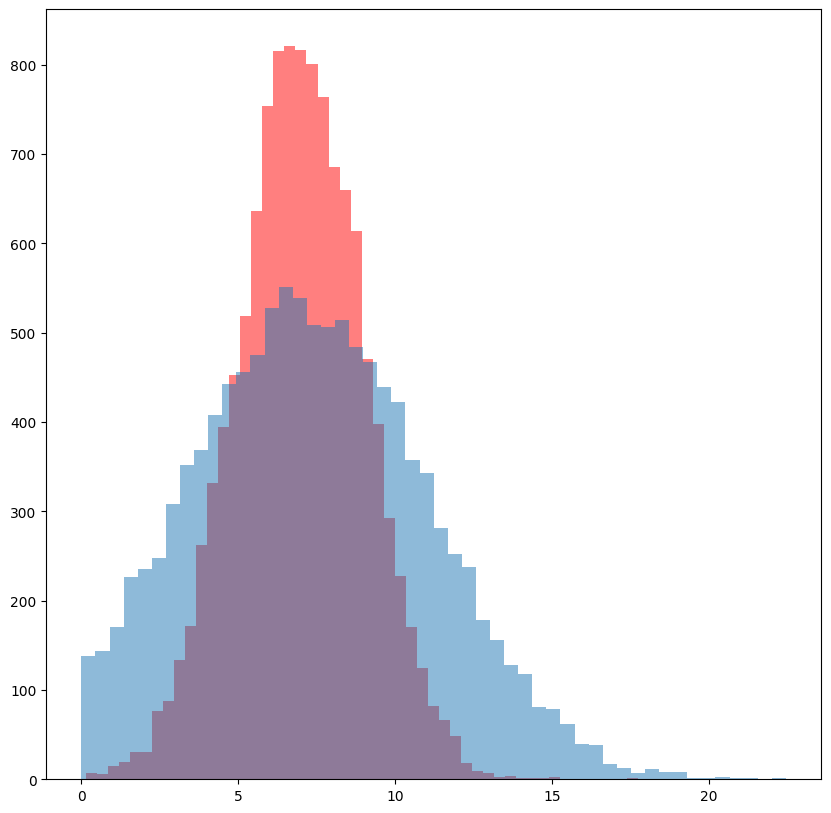

In [36]:
plt.figure(figsize=(10, 10))
control_visit_all = group_a['av_site visit']
test_visit_all = group_b['av_site visit']

plt.hist(control_visit_all, color='r', bins=50, alpha = 0.5)
plt.hist(test_visit_all,  bins=50, alpha = 0.5)

plt.show() # в версии В время затрачивают больше

In [38]:
stats.ttest_ind(control_visit_all, test_visit_all)

TtestResult(statistic=-11.07730611729516, pvalue=1.905574901675584e-28, df=23182.0)

In [40]:
# Тест Хи-квадрат для дохода

n1 = group_a.purchase.value_counts().sum()
n2 = group_b.purchase.value_counts().sum()
k1 = group_a.purchase.value_counts()[1]
k2 = group_b.purchase.value_counts()[1]

In [41]:
from statsmodels.stats import proportion

chisq, pvalue, table = proportion.proportions_chisquare(np.array([k1, k2]),
                                                   np.array([n1, n2]))

print('Results are ','chisq =%.3f, pvalue = %.3f'%(chisq, pvalue))

Results are  chisq =1.048, pvalue = 0.306


pvalue > 0.05 -> по метрике конверсия статистических раличий нет.

In [42]:
z_score, z_pvalue = proportion.proportions_ztest(np.array([k1, k2]),
                                                   np.array([n1, n2]))
print('Results are ','z_score =%.3f, pvalue = %.3f'%(z_score, z_pvalue))

Results are  z_score =1.024, pvalue = 0.306


In [47]:
 group_a.revenue

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
11830    0.0
11831    0.0
11832    0.0
11833    0.0
11834    0.0
Name: revenue, Length: 11829, dtype: float64

 Выбор теста. APU -average per user revenue - средний доход на пользователя
 * purchase (покупка) mean 0,02% - пользователи, которые покупали -> ненормальное распределние
 * колличественные данные (0/1)
 * независимые выборки

 Используем тест mannwhitneyu

In [48]:
stats.mannwhitneyu(x = group_a.revenue.values, y = group_b.revenue.values)

MannwhitneyuResult(statistic=67287553.0, pvalue=0.306808963067974)

In [50]:
# Average revenue per paying user, средняя выручка на одного платящего пользователя
stats.mannwhitneyu(x = group_a.query('purchase == 1').revenue.values, y = group_b.query('purchase == 1').revenue.values)

MannwhitneyuResult(statistic=28485.5, pvalue=0.902319344132039)

Вывод: Статистических различий между группами по доходу нет. В группе В больше времени пользователь проводит на сайте. + баги при тестировании. Оставляем без изменений.